# Learning outcomes
- Qualify the image segmentation performances: Intersection over union (IoU)
- Image gradients -> edge detection (image segmentation method)
- Contour (curves joining the boundaries of object (homogeneous region))
- Contour properties and features (area, perimeter, center of mass, bounding box).
- Blob detection (if managed to cover)

## Setup

In [1]:
!pip install requests

In [2]:
import sys
assert sys.version_info >= (3, 7)

import numpy as np
import cv2 as cv
from util_func import *

## IoU
Formula: 


$$IOU = \frac {|A \cap B|}{|A \cup B|}$$

In [3]:
def computeIOU(boxA, boxB):
    """Args:
    It should be (x1, y1, x2, y2)"""
    x_start = max(boxA[0], boxB[0])
    y_start = max(boxA[1], boxB[1])
    x_end = min(boxA[2], boxB[2])
    y_end = min(boxA[3], boxB[3])
    
    interArea = max(0, x_end - x_start + 1) * max(0, y_end - y_start + 1) 
    ## + 1 to ensure cover every region 0.5 up and 0.5 bottom
    
    #area of A and area of B 
    areaA = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    areaB = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    return interArea/ (areaA + areaB - interArea)

In [4]:
img = cv.imread("images/lena.jfif")

In [5]:
boxes = cv.selectROIs("boxes", img, showCrosshair = False)

cv.waitKey(0)
cv.destroyAllWindows()

In [6]:
boxes
#x, y, w, h

array([[ 68,  67, 100, 108],
       [ 78,  73,  82, 104]])

In [7]:
def convert_xywh_to_xyxy(box):
    return [box[0], box[1], box[0]+box[2], box[1]+ box[3]]

In [8]:
gt = convert_xywh_to_xyxy(boxes[0])
pred = convert_xywh_to_xyxy(boxes[1])

img_copy = img.copy()
cv.rectangle(img_copy, (gt[0], gt[1]), (gt[2], gt[3]), (0, 0, 255), 1)
cv.rectangle(img_copy, (pred[0], pred[1]), (pred[2], pred[3]), (0, 0, 255), 1)
cv.putText(img_copy, f"IOU: {computeIOU(gt, pred):.3f}", (10, 25),
          cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

show_img("IOU", img_copy)

# inassignment: threshold = 0.55

## Image gradients / edge detection
One of the most common operators: Sobel. At the backend, convolution with specific kernel:

$$\begin{bmatrix} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{bmatrix}$$

***Basically is transformation***

### caveat (bit depth)

In [9]:
img = cv.imread("images/wood_planck.jfif", 0)
## only on grayscale

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

show_img("binary", th)

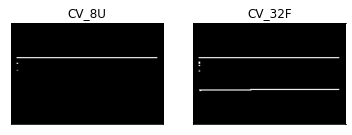

In [10]:
sobelx_8u = cv.Sobel(th, cv.CV_8U, 0, 1, ksize = -1) # 0, 1 is sobely, 1, 0 is sobelx, it is dx, dy
# can only get large negative value which get no edge

# correct way
sobelx_32f = cv.Sobel(th, cv.CV_32F, 0, 1, ksize = -1) # ksize = -1 --- Scharr operator -3 -10 -3 | 0 0 0 | 3 10 3 greater kernel
sobelx = cv.convertScaleAbs(sobelx_32f)
# convert to absolute (positive)

plt.subplot(121), plt_img(sobelx_8u, "CV_8U")
plt.subplot(122), plt_img(sobelx, "CV_32F")
plt.show()

### contruct gradient map

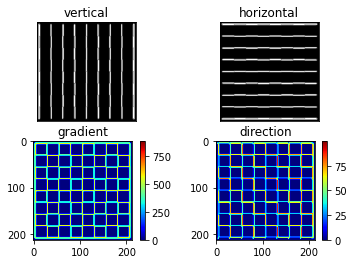

In [11]:
img = cv.imread("images/chessboard.png", 0)

# apply sobel x and sobel y
sobelx = cv.Sobel(img, cv.CV_32F, 1, 0)
sobelx_8u = cv.convertScaleAbs(sobelx)
sobely = cv.Sobel(img, cv.CV_32F, 0, 1)
sobely_8u = cv.convertScaleAbs(sobely)

# gradient
gradient = cv.magnitude(sobelx, sobely)
# direction
direction = np.arctan2(sobelx, sobely) * 180 / np.pi % 100 #convert from radient to degree

plt.subplot(221), plt_img(sobelx_8u, "vertical") #8u suitable for display
plt.subplot(222), plt_img(sobely_8u, "horizontal")
plt.subplot(223), plt.imshow(gradient, cmap="jet"), plt.title("gradient"), plt.colorbar()
plt.subplot(224), plt.imshow(direction, cmap="jet"), plt.title("direction"), plt.colorbar()

plt.show()

## canny edge detector
- Enhance accuracy by reducing false positives
- Flexible

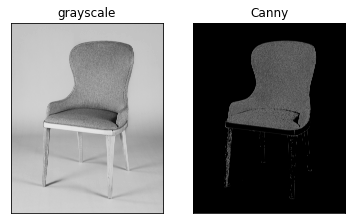

In [12]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 100, 300)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")
plt.show()

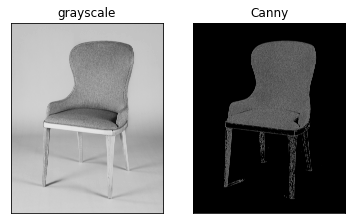

In [13]:
img = cv.imread("images/chair.jpg", 0)

edge = cv.Canny(img, 30, 150)

plt.subplot(121), plt_img(img, "grayscale")
plt.subplot(122), plt_img(edge, "Canny")
plt.show()

In [14]:
# simple example: adjust one parameter: threshold1
img = cv.imread("images/bridge.jfif")
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

ratio = 2.5 
ksize = 3
wn = "Canny"
trackbarName = "Threshold1"

def cannyThreshold(val):
    """val is Threshold1"""
    edge = cv.Canny(gray, val, val * ratio, apertureSize= ksize)
    #create mask
    mask = edge != 0
    res = img * (mask[:, :, None].astype(np.uint8))
    cv.imshow(wn, res)
    
cv.namedWindow(wn)
cv.createTrackbar(trackbarName, wn, 10, 100, cannyThreshold)

cv.waitKey(0)
cv.destroyAllWindows()

In [15]:
def auto_canny(img, method, sigma=0.33): #0.33 is default best
    """Args:
    img: grayscale image
    method: median, otsu, triangle
    sigma = 0.33 (default)"""
    if method == "median":
        Th = np.median(img)
    elif method == "triangle":
        Th = cv.threshold(img, 0, 255, cv.THRESH_TRIANGLE)[0]
    elif method == "otsu":
        Th = cv.threshold(img, 0, 255, cv.THRESH_OTSU)[0]
        
    Thresh1 = (1-sigma) * Th
    Thresh2 = (1+sigma) * Th
    
    return cv.Canny(img, Thresh1, Thresh2)

### Contour detection
1. Read an image
2. Threshold / Edge detection
3. The output from step 2 can be parse into 'cv.findContour()'.
4. (Optional) draw contour, 'cv.drawContour()'.

In [16]:
rect = np.zeros((256, 256), dtype = np.uint8)

cv.rectangle(rect, (25, 25), (231, 231), 255, -1)

show_img("rectangle", rect)

In [17]:
contours, _ = cv.findContours(rect, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

print(contours)

(array([[[ 25,  25]],

       [[ 25, 231]],

       [[231, 231]],

       [[231,  25]]], dtype=int32),)


In [18]:
type(contours)

tuple

In [19]:
contours[0].shape

(4, 1, 2)

In [20]:
img_bgr = cv.cvtColor(rect, cv.COLOR_GRAY2BGR)

cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 2) # -1 means draws every contours

show_img("contours", img_bgr)

In [21]:
img = cv.imread("images/monitor.jfif", 0)

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

#contour
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, contours, -1, (0,255,0), 2)

show_img("contours", img_bgr)

In [22]:
len(contours)

12

In [23]:
contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 2)

show_img("contours", img_bgr)

In [24]:
# simple way to sift through contours
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# select the contour that has the highest number of points
length = [len(c) for c in contours]
cnt = contours[np.argmax(length)]

img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, cnt, -1, (0, 255, 0), 2)

show_img("contours", img_bgr)

## Contour features
- area
- perimeter
- centroid
- bounding box

In [25]:
M = cv.moments(cnt)
print(M)

{'m00': 37113.5, 'm10': 3913689.5, 'm01': 3849569.1666666665, 'm20': 529272493.25, 'm11': 402572898.125, 'm02': 519454930.25, 'm30': 80631725758.65001, 'm21': 53484537787.45, 'm12': 53828827220.55, 'm03': 80175930424.35, 'mu20': 116566456.29821026, 'mu11': -3371527.140929699, 'mu02': 120161337.11136603, 'mu30': 234618732.78678894, 'mu21': -702775455.4171028, 'mu12': -249269762.75935364, 'mu03': 1368584318.4292145, 'nu20': 0.08462716040157804, 'nu11': -0.0024477261916909816, 'nu02': 0.08723704119285126, 'nu30': 0.0008841641534443626, 'nu21': -0.002648419664618219, 'nu12': -0.0009393767758931957, 'nu03': 0.005157530180767104}


In [26]:
# centroid

cx = int(M["m10"] / M['m00'])
cy = int(M['m01'] / M['m00'])

print(f"The centroid of monitor contour: {(cx, cy)}.")

The centroid of monitor contour: (105, 103).


In [27]:
# area and perimeter
area = cv.contourArea(cnt)
peri = cv.arcLength(cnt, True)

print(f"area of monitor contour: {area}")
print(f"perimeter of monitor contour: {peri:.3f}")

area of monitor contour: 37113.5
perimeter of monitor contour: 1056.777


In [28]:
# apply edge detection and contour properties to segment
img = cv.imread("images/remote-controller.webp", 0)

#show_img("img", img)

th = cv.threshold(img, 200, 255, cv.THRESH_BINARY_INV)[1]

#contour
contours, _ = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

length = [len(c) for c in contours]
cnt = contours[np.argmax(length)]

img_bgr = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_bgr, contours, -1, (0, 255, 0), 2)

epsilon = 0.1*cv.arcLength(cnt,True)
approx = cv.approxPolyDP(cnt,epsilon,True)

show_img("contours", img_bgr)

In [29]:
print(cv.__version__)
epsilon = 0.1*cv.arcLength(cnt,True)
approx = cv.approxPolyDP(cnt,epsilon,True)

4.8.0


In [30]:
# resize -> grayscale -> bilateral filter -> edge (Canny) -> find contour -> area  -> DP approximation
img = cv.imread("images/remote-controller.webp")

factor = 300 / img.shape[1]
img = cv.resize(img, None, fx = factor, fy = factor)

gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

blur = cv.bilateralFilter(gray, 7, 19, 13)

edge = auto_canny(blur, method="triangle")

show_img("edge", edge)

In [31]:
contours, _ = cv.findContours(edge, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# sort the contour with respect to contour area in descending order, and grab the first 5 largest contours
contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
screen = None

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx) == 4:
        screen = c
        break

        
img_copy = img.copy()        
cv.drawContours(img, [screen], -1, (0, 255, 0), 2)
show_img("contour", img_copy)

## Additional contour properties
$$circularity = \frac{4 \times \pi \times Area}{perimeter^2}$$

## Demo on red color segmentation

In [32]:
## two pairs of ranges

redLow1 = (0, 90, 40)
redHigh1 = (10, 255, 210)

redLow2 = (170, 90, 40)
redHigh2 = (179, 255, 210)

cap = cv.VideoCapture(0)

if not cap.isOpened():
    sys.exit("No webcam detected")
    
fixed_width = min_area = 500
factor = fixed_width / cap.get(3) #frame width
kernel = np.ones((3, 3), dtype=np.uint8)

while True:
    ret, frame = cap.read()
    
    if not ret:
        print("No frame received")
        break
    
    # resize -> blurring -> change to HSV -> mask integration ->  morphological operation
    # find contours -> bounding box
    resized = cv.resize(frame, None, fx=factor, fy=factor)
    blur = cv.GaussianBlur(resized, (5, 5), 0)
    img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
    
    mask1 = cv.inRange(img_hsv, redLow1, redHigh1)
    mask2 = cv.inRange(img_hsv, redLow2, redHigh2)
    mask = cv.add(mask1, mask2)
    
    #Opening to remove noises
    mask = cv.morphologyEx(mask, cv.MORPH_OPEN, kernel, iterations = 2) # iteration no more than 5
    
    #contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    bbs = []
    centroids = []
    
    for c in contours:
        area = cv.contourArea(c)
        
        if area > min_area:
            bb = cv.boundingRect(c)
            bbs.append(bb)
            M = cv.moments(c)
            cx, cy = int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"])
            centroids.append((cx, cy))
    
    for bb, centroid in zip(bbs, centroids):
        x, y, w, h = bb
        cv.rectangle(resized, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv.circle(resized, centroid, 2, (255, 0, 0), -1)
        
    cv.imshow("red object", resized)
    k = cv.waitKey(1) & 0xFF
    if k == 27:
        break
        
cv.destroyAllWindows()        
cap.release()

## Activity

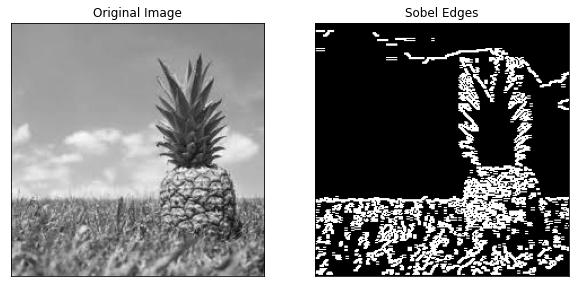

In [33]:
# Exercise 1
#Sobel

img = cv.imread('images/pineapple.jfif', 0)
#gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

th = cv.threshold(img, 150, 255, cv.THRESH_BINARY_INV)[1]


#show_img("pineapple", img)

sobelx_32f = cv.Sobel(th, cv.CV_32F, 0, 1, ksize = 3) 
# ksize = -1 --- Scharr operator -3 -10 -3 | 0 0 0 | 3 10 3 greater kernel
sobelx = cv.convertScaleAbs(sobelx_32f)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(sobelx, cmap='gray')
plt.title('Sobel Edges'), plt.xticks([]), plt.yticks([])
plt.show()

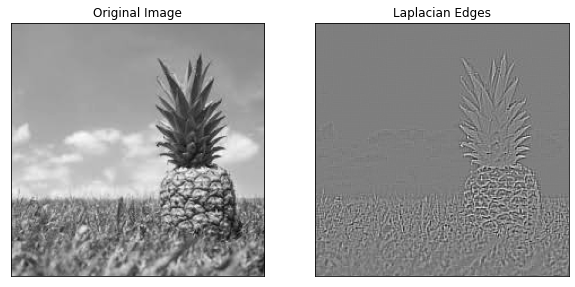

In [34]:
#Laplacian
lap_edge = cv.Laplacian(img, cv.CV_32F, ksize=3)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(lap_edge, cmap='gray')
plt.title('Laplacian Edges'), plt.xticks([]), plt.yticks([])
plt.show()

In [35]:
np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
# np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

array([[-1,  0,  1],
       [-1,  0,  1],
       [-1,  0,  1]])

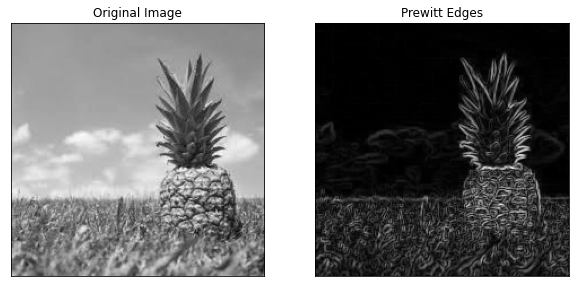

In [36]:
#Prewitt
# Apply the Prewitt operator
prewitt_x = cv.filter2D(img, cv.CV_32F, np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]]))
prewitt_y = cv.filter2D(img, cv.CV_32F, np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]]))

# Combine the x and y gradient components
prewitt_edges = np.sqrt(prewitt_x**2 + prewitt_y**2)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(prewitt_edges, cmap='gray')
plt.title('Prewitt Edges'), plt.xticks([]), plt.yticks([])
plt.show()

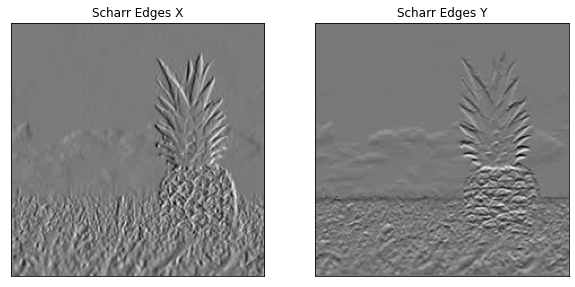

In [37]:
#Scharr 
#scharr_mask = np.array([[-3, -10, -3], [0, 0, 0], [3, 10, 3]])
# scharrx = cv.Scharr(img, cv.CV_32F, 1, 0)
# scharry = cv.Scharr(img, cv.CV_32F, 0, 1)
# #scharr_edge = np.hstack([scharrx, scharry])

# Apply the Scharr operator
scharr_x = cv.Scharr(img, cv.CV_32F, 1, 0)
scharr_y = cv.Scharr(img, cv.CV_32F, 0, 1)

plt.figure(figsize=(10, 5))
# plt.subplot(121), plt.imshow(img, cmap='gray')
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(121), plt.imshow(scharr_x, cmap='gray')
plt.title('Scharr Edges X'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(scharr_y, cmap='gray')
plt.title('Scharr Edges Y'), plt.xticks([]), plt.yticks([])
plt.show()

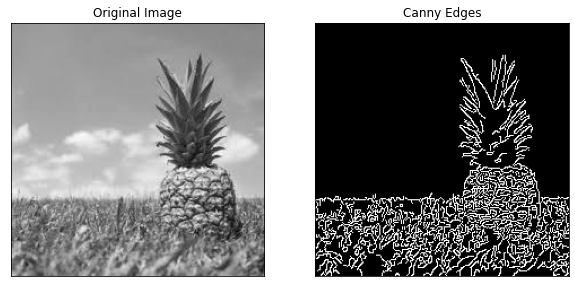

In [38]:
#Canny
canny_edge = cv.Canny(img, 100, 300, apertureSize=3)

plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(canny_edge, cmap='gray')
plt.title('Canny Edges'), plt.xticks([]), plt.yticks([])
plt.show()

Result: 
    1. Sobel - the edges detected has some noises and unclear
    2. Laplacian - the edges detected are clear but not applicable on the complex background such as the grasses
    3. Prewitt - the edges detected are somehow blur
    4. Scharr - the edges detected almost same as Laplacian but become displayed in 3D, clear
    5. Canny - the edges detected are quite sharp.

In [39]:
##Exercise 2
img = cv.imread('images/electronic.jfif')

whiteLow1 = (0, 0, 140)
whiteHigh1 = (255, 30, 255)

blur = cv.GaussianBlur(img, (5, 5), 0)
img_hsv = cv.cvtColor(blur, cv.COLOR_BGR2HSV)
whitemask = cv.inRange(img_hsv, whiteLow1, whiteHigh1)

# kernel = np.ones((3, 3), dtype=np.uint8)
#mask = cv.morphologyEx(whitemask, cv.MORPH_OPEN, kernel, iterations = 2) # iteration no more than 5

contours, _ = cv.findContours(whitemask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
# laptop = None
# for c in contours:
#     peri = cv.arcLength(c, True)
#     approx = cv.approxPolyDP(c, 0.1*peri, True)
#     if len(approx) == 4:
#         laptop = c
#         break

# img_copy = img.copy()
# cv.drawContours(img_copy, [laptop], -1, (0, 255, 0), 2) # -1 means draws every contours
# show_img("laptop", img_copy)

######if want to draw a bounding box only laptop, uncomment these 


img_copy = img.copy()
cv.drawContours(img_copy, contours, -1, (0, 255, 0), 2) # -1 means draws every contours
for contour in contours:
    x, y, w, h = cv.boundingRect(contour)
    cv.rectangle(img_copy, (x, y), (x+w, y+h), (255, 0, 0), 2)

show_img("white objects", img_copy)


In [40]:
#Exercise 3

img = cv.imread("images/clock.jpg")
blur = cv.GaussianBlur(img, (3, 3), 0)
gray = cv.cvtColor(blur, cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray, 50, 150)


# show_img("img", edges)
contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# contours = sorted(contours, key=cv.contourArea, reverse=True)[:1]
contours = sorted(contours, key=cv.contourArea, reverse=True)[:5]
clock = None

for c in contours:
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.1*peri, True)
    
    if len(approx) == 4:
        clock = c
        break

img_copy = img.copy()
cv.drawContours(img_copy, [clock], -1, (0, 255, 0), 2) # -1 means draws every contours
show_img("laptop", img_copy)


